In [1]:
from SAS_calculator.sascorer import calculateScore
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import MolToSmiles
import rdkit
from rdkit import Chem
import numpy as np

def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi

    Parameters:
    smi (string) : smile string to be canonicalized

    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful
    '''
    try:
        mol = MolFromSmiles(smi, sanitize=True)
        smi_canon = MolToSmiles(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)
    
def get_ECFP4(mol):
    return AllChem.GetMorganFingerprint(mol, 2)

def get_logP(mol):
    '''Calculate logP of a molecule

    Parameters:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object, for which logP is to calculates

    Returns:
    float : logP of molecule (mol)
    '''
    return Descriptors.MolLogP(mol)

def get_fp_score(mol, target):
    fp_target = get_ECFP4(target)
    fp_mol = get_ECFP4(mol)
    score = TanimotoSimilarity(fp_mol, fp_target)
    return score

def get_sas_score(smi):
    mol, smi_canon, did_convert = sanitize_smiles(smi)
    if did_convert:
        sas_score = calculateScore(mol)
        return sas_score
    else:
        return None
        
def get_ringP(smi):
    mol, smi_canon, did_convert = sanitize_smiles(smi)
    if did_convert:
        cycle_list = mol.GetRingInfo().AtomRings()
        if len(cycle_list) == 0:
            cycle_length = 0
        else:
            cycle_length = max([len(j) for j in cycle_list])
        if cycle_length <= 6:
            cycle_length = 0
        else:
            cycle_length = cycle_length - 6
    else:
        raise Exception('Invalid smile encountered while atempting to calculate Ring penalty')
    return cycle_length

def calc_plogp(logP_calculated, SAS_calculated, RingP_calculated):
    logP_norm = (logP_calculated - 2.4729421499641497) / 1.4157879815362406
    SAS_norm = (SAS_calculated - 3.0470797085649894) / 0.830643172314514
    RingP_norm = (RingP_calculated - 0.038131530820234766) / 0.2240274735210179
    
    return logP_norm, SAS_norm, RingP_norm


In [2]:
f = open('.//data//logp_800.txt')
lines = f.readlines()
smiles = []
for line in lines:
    smiles.append(line.strip())

In [3]:
len(smiles)

800

In [4]:
basement = []
for smi in smiles:
    mol, smi_canon, valid = sanitize_smiles(smi)
    logp = get_logP(mol)
    sas = get_sas_score(smi_canon)
    ringpenalty = get_ringP(smi_canon)
    plogp = logp-sas-ringpenalty
    basement.append(plogp)

In [5]:
len(basement)

800

In [6]:
path = './/output//constrained//0.4//'
files = []
for i in range(1, 801):
    files.append("{}{}_similarity0.4_molecular(max).txt".format(path, i))

In [7]:
files[0]

'.//output//constrained//0.4//1_similarity0.4_molecular(max).txt'

In [8]:
imp_avg1 = []
best_smiles1 = []
for i, file in enumerate(files):
    f = open(file)
    lines = f.readlines()
    improvements = []
    opt_smiles = []
    opt_logp = [] 
    for line in lines:
        line = line.strip().split(',')
        opt_smiles.append(line[1])
    for smi in opt_smiles:
        mol, smi_canon, valid = sanitize_smiles(smi)
        logp = get_logP(mol)
        sas = get_sas_score(smi_canon)
        ringpenalty = get_ringP(smi_canon)
        plogp = logp-sas-ringpenalty
        opt_logp.append(plogp)
    
    best = np.array(max(opt_logp))
    improvement = best - basement[i]
    idx = opt_logp.index(max(opt_logp))
    imp_avg1.append(improvement)
    best_smiles1.append(opt_smiles[idx])

In [9]:
imp_avg1 = np.array(imp_avg1)
mean1 = imp_avg1.mean()
std1 = imp_avg1.std()

In [10]:
print(mean1, std1)

5.531372379327557 1.2965603745170953


In [11]:
path = './/output//constrained//0.6//'
files = []
for i in range(1, 801):
    files.append("{}{}_similarity0.6_molecular(max).txt".format(path, i))

In [12]:
files[0]

'.//output//constrained//0.6//1_similarity0.6_molecular(max).txt'

In [13]:
imp_avg2 = []
best_smiles2 = []
for i, file in enumerate(files):
    f = open(file)
    lines = f.readlines()
    improvements = []
    opt_smiles = []
    opt_logp = [] 
    for line in lines:
        line = line.strip().split(',')
        opt_smiles.append(line[1])
    for smi in opt_smiles:
        mol, smi_canon, valid = sanitize_smiles(smi)
        logp = get_logP(mol)
        sas = get_sas_score(smi_canon)
        ringpenalty = get_ringP(smi_canon)
        plogp = logp-sas-ringpenalty
        opt_logp.append(plogp)
    
    best = np.array(max(opt_logp))
    improvement = best - basement[i]
    idx = opt_logp.index(max(opt_logp))
    imp_avg2.append(improvement)
    best_smiles2.append(opt_smiles[idx])

In [14]:
imp_avg2 = np.array(imp_avg2)
mean2 = imp_avg2.mean()
std2 = imp_avg2.std()

In [15]:
print(mean2, std2)

3.672409621477654 1.139262106235807


In [16]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

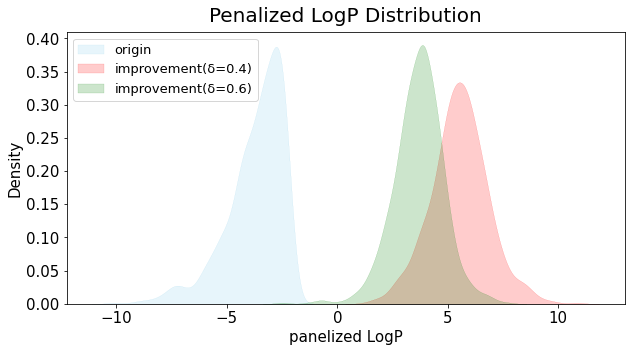

In [17]:
fig = plt.figure(figsize = (10,5))
plt.ylabel('', fontsize=15)
plt.xlabel('panelized LogP', fontsize=15)
plt.title('Penalized LogP Distribution',fontsize=20, pad=10)
sns.kdeplot(basement, color='skyblue', label='origin', shade=True,alpha=.2, linewidth=0.1)
sns.kdeplot(imp_avg1, color='red', label='improvement(δ=0.4)', shade=True,alpha=.2, linewidth=0.1)
sns.kdeplot(imp_avg2, color='green', label='improvement(δ=0.6)', shade=True, alpha=.2, linewidth=0.1)
plt.legend(loc='upper left', fontsize=13)